In [1]:
import pandas as pd
import os

BASE_DIR="/home/aiops/zhuty/ret_pretraining_data/id_added/cc/train"
dfs = []
for i in range(0, 100):
    chunk = pd.read_csv(os.path.join(BASE_DIR, "chunk_{}_lengths.csv".format(i)))
    dfs.append(chunk)
df = pd.concat(dfs, ignore_index=True)

print(df['length'].describe())
print("Total number of tokens (B): ", df['length'].sum()/1e9)

# df = pd.read_csv("chunk_99_lengths.csv")

count    1.575382e+07
mean     1.972632e+03
std      4.566829e+03
min      4.500000e+01
25%      6.510000e+02
50%      1.067000e+03
75%      1.867000e+03
max      5.942720e+05
Name: length, dtype: float64
Total number of tokens (B):  31.076485813


In [15]:
# get how many lengths are smaller than 1k, 2k, 4k, 8k
print("Number of documents smaller than 1k: ", df[df['length'] < 1000].shape[0], "Percentage: ", df[df['length'] < 1000].shape[0]/df.shape[0])
print("Number of documents smaller than 2k: ", df[df['length'] < 2000].shape[0], "Percentage: ", df[df['length'] < 2000].shape[0]/df.shape[0])
print("Number of documents smaller than 4k: ", df[df['length'] < 4000].shape[0], "Percentage: ", df[df['length'] < 4000].shape[0]/df.shape[0])
print("Number of documents smaller than 8k: ", df[df['length'] < 8000].shape[0], "Percentage: ", df[df['length'] < 8000].shape[0]/df.shape[0])

Number of documents smaller than 1k:  7342657 Percentage:  0.4660875180972026
Number of documents smaller than 2k:  12168793 Percentage:  0.7724346279022175
Number of documents smaller than 4k:  14390219 Percentage:  0.9134433841299149
Number of documents smaller than 8k:  15227710 Percentage:  0.9666045356883691


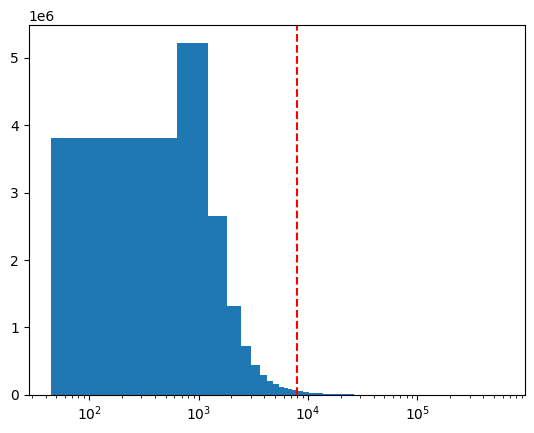

In [14]:
import matplotlib.pyplot as plt
# plot the distribution of the lengths in log scale
plt.hist(df['length'], bins=1000)
plt.xscale('log')
# draw the line of 8k
plt.axvline(x=8000, color='r', linestyle='--')
plt.show()